### This notebook doesn't contain any data collection part, because we've been using Google's colab GPU. And there're lots of unnecessary difficulties for collecting data from webcam using google colab.

In [1]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import cv2
import os
import time
import uuid
IMAGES_PATH = os.path.join('data','images')

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [51]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
#Load images into tensorflow dataset
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

In [6]:
images.as_numpy_iterator().next()

b'data/images/24aae577-4ac4-11ed-89b4-088fc30aec75.jpg'

In [7]:
#Let's transform images into numeric-matrixes
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [8]:
#Apply numeric transofmation for created images
images = images.map(load_image)

In [9]:
type(images) #Check if it's a tensorflow pipeline

tensorflow.python.data.ops.dataset_ops.MapDataset

In [10]:
image_generator = images.batch(4).as_numpy_iterator()

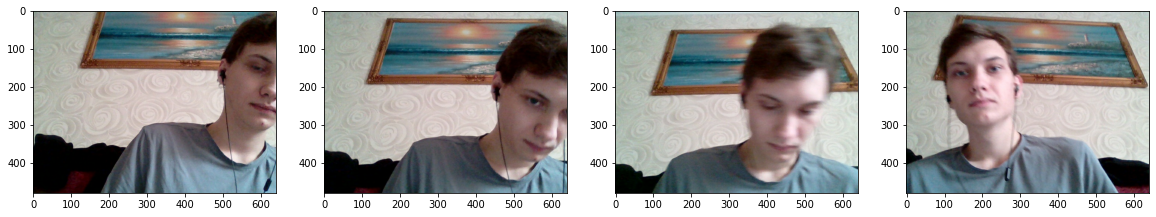

In [13]:
#Plotting images using matplotlib
#You can run this cell many times and go through all images 
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [14]:
mypath = 'data/images/'
image_names = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

### Train Test Validation process

In [19]:
train_volume = 63 # ~70% of data is used for training 
test_volume = 14 # ~16% for tets, validation volume doesnt require initialization

# Of course i could use sklearn train test split method, but i wanted to it myself!

train_images = np.random.choice(image_names, train_volume, replace=False).tolist()
test_and_val = [name for name in image_names if name not in train_images]
test_images = np.random.choice(test_and_val, test_volume, replace=False).tolist()
val_images = [name for name in test_and_val if name not in test_images]


#Checkout if evrything right
assert len(set(train_images+test_images+val_images)) == 90, "Data leaked"
assert len(train_images) + len(test_images) + len(val_images) == 90, "Unmatched volume"

In [21]:
#Let's put those files in different folders
import shutil
for train_image in train_images:
  shutil.copyfile('data/images/'+train_image, 'data/train/images/'+train_image)

In [22]:
for test_image in test_images:
  shutil.copyfile('data/images/'+test_image, 'data/test/images/'+test_image)

In [23]:
for val_image in val_images:
  shutil.copyfile('data/images/'+val_image, 'data/val/images/'+val_image)

In [24]:
#Let's just loop through foulders and put matched labels in label folder
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data/', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data/','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data/',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

In [25]:
#Let's make image Augmentation on images and labels
#Gonna use albumentations library, that allow us to generate more image data
import albumentations as alb
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [26]:
img = cv2.imread(os.path.join('data', 'train', 'images','24aae577-4ac4-11ed-89b4-088fc30aec75.jpg'))

In [27]:
with open(os.path.join('data', 'train', 'labels', '24aae577-4ac4-11ed-89b4-088fc30aec75.json'), 'r') as f:
    label = json.load(f) #We have to extract labels from our labelme targen jsons

In [28]:
label['shapes'][0]['points'] #Just check if labels are fine

[[260.3043478260869, 110.73913043478257],
 [429.86956521739125, 327.0434782608695]]

In [29]:
#We want to stetch this matrix into 1D array
box_coords = []
for i in label['shapes'][0]['points']:
    box_coords += i
box_coords

[260.3043478260869, 110.73913043478257, 429.86956521739125, 327.0434782608695]

### But this will cause a big mistace if we want to stretch 2D matrix this way, there are some images that doesn't contain face in it, and in this way coords must be zeros


In [30]:
#This is code is naive, but it shows logic of matrix stretching with filled zeros
box_coords = [0,0,0,0]
box_coords[0] = label['shapes'][0]['points'][0][0]
box_coords[1] = label['shapes'][0]['points'][0][1]
box_coords[2] = label['shapes'][0]['points'][1][0]
box_coords[3] = label['shapes'][0]['points'][1][1]
box_coords

[260.3043478260869, 110.73913043478257, 429.86956521739125, 327.0434782608695]

In [32]:
#Also we have to normalize this vector for NN 
box_coords = list(np.divide(box_coords, [640,480,640,480])) 
#This part depends on what resolution your image has

box_coords

[0.40672554347826073,
 0.23070652173913034,
 0.6716711956521738,
 0.6813405797101448]

In [33]:
augmented = augmentor(image=img, bboxes=[box_coords], class_labels=['face'])
augmented['bboxes']

[(0.24512077294685974,
  0.3065700483091789,
  0.6219323671497583,
  0.7872463768115943)]

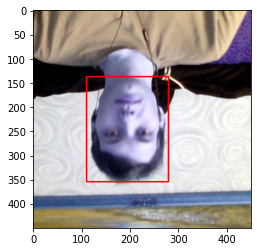

In [35]:
# Let's see how single image was transformed
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

### Now we've done with single image pipeline, let's get to full data

I choose to create 100 images for each base image i have, i thout it will be enough

In [36]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        box_coords = [0,0,0.00001,0.00001] #This will be coordinates for images without face 
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            box_coords[0] = label['shapes'][0]['points'][0][0]
            box_coords[1] = label['shapes'][0]['points'][0][1]
            box_coords[2] = label['shapes'][0]['points'][1][0]
            box_coords[3] = label['shapes'][0]['points'][1][1]
            box_coords = list(np.divide(box_coords, [640,480,640,480]))

        try: 
            for x in range(100): #I choose to generate 100 images for each base image
                augmented = augmentor(image=img, bboxes=[box_coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.14563802083333335, 0.4698350694444445, 0.0, 0.8645833333333334, 'face'].
x_max is less than or equal to x_min for bbox [0.13343098958333335, 0.2593315972222222, 0.0, 0.8041666666666667, 'face'].
x_max is less than or equal to x_min for bbox [0.4581380208333334, 0.3309461805555556, 0.1879557291666667, 0.6749131944444445, 'face'].
x_max is less than or equal to x_min for bbox [0.3702473958333334, 0.31467013888888895, 0.1147135416666667, 0.7172309027777779, 'face'].
x_max is less than or equal to x_min for bbox [0.459765625, 0.3233506944444445, 0.20830078125, 0.7942708333333334, 'face'].
x_max is less than or equal to x_min for bbox [0.4980143229166667, 0.3331163194444445, 0.2555013020833333, 0.7769097222222222, 'face'].
x_max is less than or equal to x_min for bbox [0.37919921875, 0.11610243055555557, 0.058561197916666675, 0.7302517361111112, 'face'].
x_max is less than or equal to x_min for bbox [0.2563151041666667, 0.4676649305555556, 0.

In [37]:
def load_aug_images(image_type): #Image type is test train or validation string
    loaded_aug_images = tf.data.Dataset.list_files('aug_data/'+image_type+'/images/*.jpg', shuffle=False)
    loaded_aug_images = loaded_aug_images.map(load_image)
    loaded_aug_images = loaded_aug_images.map(lambda x: tf.image.resize(x, (120,120))) #Resizing image for NN
    loaded_aug_images = loaded_aug_images.map(lambda x: x/255) #Scaling image for sigmoid in the futur
    return loaded_aug_images

train_images = load_aug_images('train')
test_images = load_aug_images('test')
val_images = load_aug_images('val')

In [38]:
train_images.as_numpy_iterator().next().shape #Just checked shape 

(120, 120, 3)

### Now let's figure out what to do with labels


In [39]:
#Now let's get to the labels 
def load_labels(label_path):
  with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
      label = json.load(f)
  return [label['class']], label['bbox']

In [40]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [41]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [43]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)


(5400, 5400, 1300, 1300, 1100, 1100)

In [44]:
#Batching and shuffling zipped images and labels
def zip_shuffle_batch(img, lbl):
    z_s_b = tf.data.Dataset.zip((img, lbl))
    z_s_b = z_s_b.shuffle(5000)
    z_s_b = z_s_b.batch(8)
    z_s_b = z_s_b.prefetch(4)
    return z_s_b
train = zip_shuffle_batch(train_images, train_labels)
test = zip_shuffle_batch(test_images, test_labels)
val = zip_shuffle_batch(val_images, val_labels)

In [45]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1]], dtype=uint8), array([[0.06836, 0.4155 , 0.5396 , 0.9893 ],
        [0.3162 , 0.2754 , 0.693  , 0.7563 ],
        [0.129  , 0.0783 , 0.54   , 0.534  ],
        [0.52   , 0.1998 , 0.875  , 0.692  ],
        [0.2874 , 0.3823 , 0.629  , 0.879  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.3567 , 0.358  , 0.732  , 0.7563 ],
        [0.09283, 0.03275, 0.564  , 0.607  ]], dtype=float16))

In [46]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()

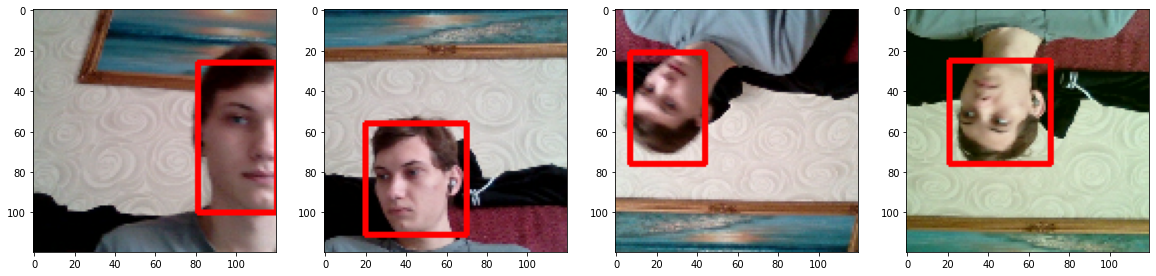

In [47]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

### Neural-Network architecture.

Object detection problem consists of two exact parts:

  1)Classification that determine what the object is. This is a binary classification 

  2) Regression problem that find coordinates for the bounding box.


So in this project i want to use VGG16 base architecture and add final prediction layers. One layer for classification problem, second is for regression problem.

To handle two outputs at the same time i'm gonna use Model API

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalMaxPooling2D, Dense 
from tensorflow.keras.applications import VGG16

In [50]:
vgg = VGG16(include_top=False) #We don't need top layers, cause we solve class and reg problem
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

Last number in output shape is a number of channels (as usual)

In [52]:
#Model architecture
def build_model(): 
    input_layer = Input(shape=(120,120,3)) #Input shape was checked above in this notebook
    
    vgg = VGG16(include_top=False)(input_layer) #Base part for my model 

    # Classification Model for detection  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1) #Hidden layer
    class2 = Dense(1, activation='sigmoid')(class1) #One output which is representing calss probability
    
    # Regression part for box bounding
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2) #Hidden layer
    #In the end i use sigmoid because i normalize coordinates by dimension of my image
    regress2 = Dense(4, activation='sigmoid')(regress1) #Four outputs representing coordinates 
    
    #Here we use Model API to handle classification and regression problems at the same time
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2]) 
    return facetracker

In [53]:
facetracker = build_model()
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [54]:
X, y = train.as_numpy_iterator().next()
X.shape #X is images and y is a labels

(8, 120, 120, 3)

In [57]:
#This is a crap prediction, just check if everything works as i expect
classes, box_coords = facetracker.predict(X)
classes, box_coords

1/1 [==============================] - 0s 18ms/step


(array([[0.46254027],
        [0.3072402 ],
        [0.35845834],
        [0.3193942 ],
        [0.33020207],
        [0.34104922],
        [0.35159332],
        [0.32377556]], dtype=float32),
 array([[0.4067437 , 0.5710461 , 0.25683922, 0.42912474],
        [0.33148038, 0.5218421 , 0.335093  , 0.4998677 ],
        [0.28921753, 0.53559756, 0.30259234, 0.3897114 ],
        [0.3086158 , 0.5619241 , 0.31967074, 0.4954219 ],
        [0.288232  , 0.5778784 , 0.30733255, 0.3885698 ],
        [0.32787848, 0.5646965 , 0.31608734, 0.4066048 ],
        [0.23770684, 0.6217163 , 0.2531019 , 0.40796632],
        [0.3883461 , 0.56243646, 0.27835545, 0.38665095]], dtype=float32))

### Lets get to Loss functions and learning rate 

In [70]:
batches_per_epoch = len(train)

#Reduce learning rate with iterations to evade overfitting and gradient-blowing
lr_decay = (1./0.75 -1)/batches_per_epoch

#I use Adam optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [71]:
def localization_loss(y_true, yhat):
    #Distance between actual coordinate and predictet coordinate
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] #Actual height of the box
    w_true = y_true[:,2] - y_true[:,0] #Actual width of the box

    h_pred = yhat[:,3] - yhat[:,1] #Predicted height
    w_pred = yhat[:,2] - yhat[:,0] #Predicted width
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred)) #Same reduction
    
    return delta_coord + delta_size #Return the localozation loss

In [72]:
classloss = tf.keras.losses.BinaryCrossentropy() #Binary classification loss
regressloss = localization_loss

In [73]:
#Just check if everything works fine
print(localization_loss(y[1], coords))
print(classloss(y[0], classes))
print(regressloss(y[1], coords))

tf.Tensor(6.0503635, shape=(), dtype=float32)
tf.Tensor(1.0593976, shape=(), dtype=float32)
tf.Tensor(6.0503635, shape=(), dtype=float32)


In [78]:
#Using Keras we gonna need init, compile, train, test and call methods

class FaceTracker(Model): 
    #Just initial parameters, we put here our builded model
    def __init__(self, tracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = tracker
    # We need to put inside compile method loss and optimizer
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss  #Define class and loc loss separatly
        self.lloss = localizationloss
        self.opt = opt
    
    # Main step, is how my model is about to train
    def train_step(self, batch, **kwargs): 
        
        X, y = batch #Get batch of data to train on
        
        with tf.GradientTape() as tape:  
            classes, coords = self.model(X, training=True) #Make prediction
            
            batch_classloss = self.closs(y[0], classes) #Calculate class loss on batch
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords) #Calculate reg loss on batch
            
            #Coefficient of 0.5 for class loss is hyperparameter
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables) #Calculate gradients
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables)) #Gradient descent
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    #Method for prediction     
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [79]:
model = FaceTracker(facetracker)

In [80]:
model.compile(opt, classloss, regressloss)

In [81]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
#Choose 10 epochs for first run, next gonna see an optimal parameter
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
675/675 [==============================] - 61s 70ms/step - total_loss: 0.2006 - class_loss: 0.0435 - regress_loss: 0.1789 - val_total_loss: 0.0678 - val_class_loss: 0.0495 - val_regress_loss: 0.0430
Epoch 2/40
675/675 [==============================] - 56s 69ms/step - total_loss: 0.0677 - class_loss: 0.0144 - regress_loss: 0.0605 - val_total_loss: 0.0497 - val_class_loss: 0.0662 - val_regress_loss: 0.0166
Epoch 3/40
675/675 [==============================] - 56s 69ms/step - total_loss: 0.0390 - class_loss: 0.0088 - regress_loss: 0.0345 - val_total_loss: 0.0138 - val_class_loss: 0.0019 - val_regress_loss: 0.0129
Epoch 4/40
675/675 [==============================] - 56s 68ms/step - total_loss: 0.0213 - class_loss: 0.0040 - regress_loss: 0.0193 - val_total_loss: 0.0084 - val_class_loss: 1.1325e-06 - val_regress_loss: 0.0084
Epoch 5/40
675/675 [==============================] - 57s 69ms/step - total_loss: 0.0187 - class_loss: 0.0044 - regress_loss: 0.0165 - val_total_loss: 0.007

In [ ]:
hist.history


{'total_loss': [0.019572822377085686,
  0.016594436019659042,
  0.00768407853320241,
  0.003083973890170455,
  0.007868198677897453,
  0.0032426544930785894,
  0.002627357840538025,
  0.0014967804308980703,
  0.0007993936305865645,
  0.00021304850815795362],
 'class_loss': [0.00011318366159684956,
  0.0022954128216952085,
  0.0011439088266342878,
  5.9118192439200357e-05,
  1.2487340427469462e-05,
  0.0016553789610043168,
  1.609327796359139e-06,
  2.5034028112713713e-06,
  2.02656246983679e-06,
  1.9222547962272074e-06],
 'regress_loss': [0.0195162296295166,
  0.015446729958057404,
  0.007112124003469944,
  0.003054414875805378,
  0.007861955091357231,
  0.002414965070784092,
  0.002626553177833557,
  0.0014955287333577871,
  0.0007983803516253829,
  0.00021208738326095045],
 'val_total_loss': [0.02936204895377159,
  0.04491293430328369,
  0.06593303382396698,
  0.01645713299512863,
  0.012515993788838387,
  0.01365913450717926,
  0.009400236420333385,
  0.01392245851457119,
  0.00963

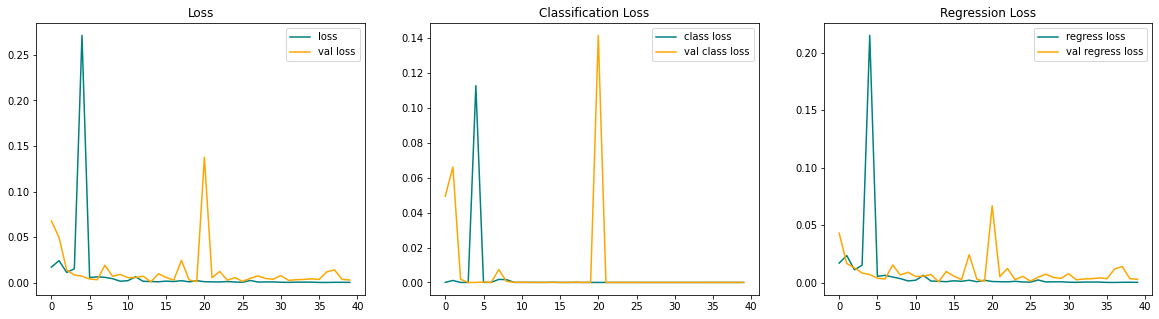

In [82]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

1/1 [==============================] - 0s 20ms/step


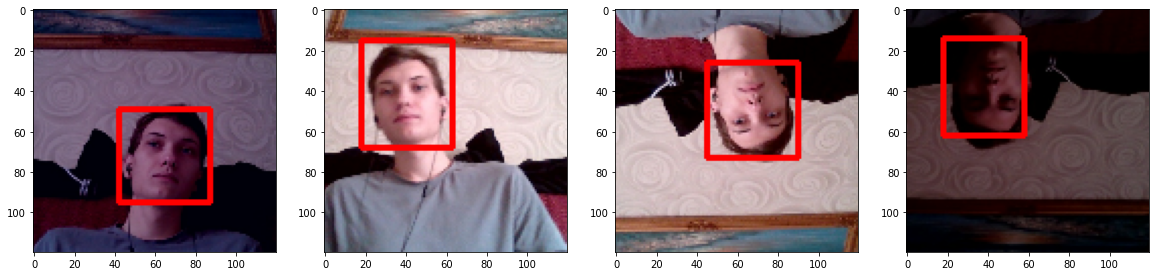

In [109]:
#Check how our model works on static test images

test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [87]:
from tensorflow.keras.models import load_model
facetracker.save('facetracker.h5')